In [11]:
import numpy as np
from collections import namedtuple
from scipy.stats import geom
from itertools import product
from quantecon import MarkovChain

## laborer model

In [49]:
# NamedTuple Model
Model = namedtuple("Model", ("α", "β"))


def create_laborer_model(α=0.3, β=0.2):
    return Model(α=α, β=β)

In [50]:
model = create_laborer_model()

model

Model(α=0.3, β=0.2)

In [51]:
np.random.rand?

In [52]:
np.random.rand()

0.2903266296734289

$$
\left[\begin{array}{cc}
1-\alpha & \alpha\\
\beta & 1-\beta
\end{array}\right]
$$

In [53]:
def laborer_update(x, model):  # update X from t to t+1
    if x == 1:
        x_ = 2 if np.random.rand() < model.α else 1
    else:
        x_ = 1 if np.random.rand() < model.β else 2
    return x_

In [54]:
def sim_chain(k, p, model):
    X = np.empty(k)
    X[0] = 1 if np.random.rand() < p else 2
    for t in range(0, k-1):
        X[t+1] = laborer_update(X[t], model)
    return X

In [68]:
K = 10_000
p = 0.5

laborer_chain = sim_chain(K, p, model)

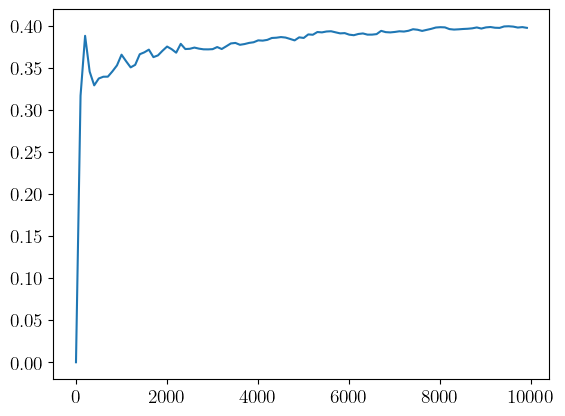

In [69]:
k_range = np.arange(1, K, 100)

plt.plot(k_range, [(laborer_chain[:k] == 1).mean() for k in k_range])

In [81]:
def test_convergence(k=10_000_000, p=0.5):

    model = create_laborer_model()
    α, β = model
    ψ_star = (1/(α + β)) * np.array([β, α])
    print(f'stationary distribution: {ψ_star}')
    X = sim_chain(k, p, model)
    ψ_e = (1/k) * np.array([sum(X == 1), sum(X == 2)])
    error = np.max(np.abs(ψ_star - ψ_e))
    approx_equal = np.allclose(ψ_star, ψ_e, rtol=0.01)
    print(f"Sup norm deviation is {error}")
    print(f"Approximate equality is {approx_equal}")

In [82]:
test_convergence()

stationary distribution: [0.4 0.6]
Sup norm deviation is 0.0003828999999999638
Approximate equality is True


In [74]:
α, β = model.α, model.β

P = np.array([[1-α, α],
              [β, 1-β]])

state_vals = np.array([1, 2])

In [76]:
mc = MarkovChain(P, state_vals)

In [77]:
mc.stationary_distributions[0]

array([0.4, 0.6])

## Inventory model

In [12]:
# NamedTuple Model
Model = namedtuple("Model", ("S", "s", "p", "φ", "h"))

def create_inventory_model(S=100,   # Order size
                           s=10,    # Order threshold
                           p=0.4):  # Demand parameter
    φ = geom(p, loc=-1) # loc sets support to {0,1,...}
    h = lambda x, d: max(x - d, 0) + S*(x <= s)
    return Model(S=S, s=s, p=p, φ=φ, h=h)

In [15]:
model = create_inventory_model()

model

Model(S=100, s=10, p=0.4, φ=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f52587e7730>, h=<function create_inventory_model.<locals>.<lambda> at 0x7f5258806440>)

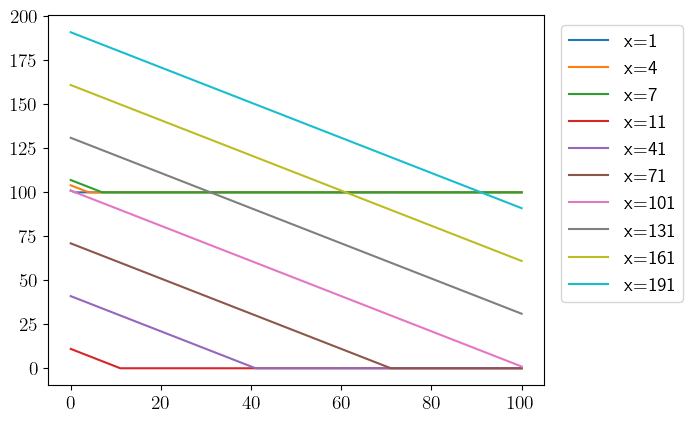

In [47]:
d_max = 100
d_range = range(d_max+1)

for x in [*range(1, 10, 3), *range(11, 200, 30)]:
    plt.plot(d_range, [model.h(x, d) for d in d_range], label=f'x={x}')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.))

In [13]:
def sim_inventories(model, ts_length=200):
    """Simulate the inventory process."""
    S, s, p, φ, h = model
    X = np.empty(ts_length)
    X[0] = S  # Initial condition
    for t in range(0, ts_length - 1):
        X[t+1] = h(X[t], φ.rvs())
    return X

In [19]:
def compute_mc(model, d_max=100):
    """Compute the transition probabilities and state."""
    S, s, p, φ, h = model
    n = S + s + 1  # Size of state space
    state_vals = np.arange(n)
    P = np.empty((n, n))
    for (i, j) in product(range(0, n), range(0, n)):
        P[i, j] = sum((h(i, d) == j)*φ.pmf(d) for d in range(d_max+1))
    return MarkovChain(P, state_vals)

In [27]:
mc = compute_mc(model)

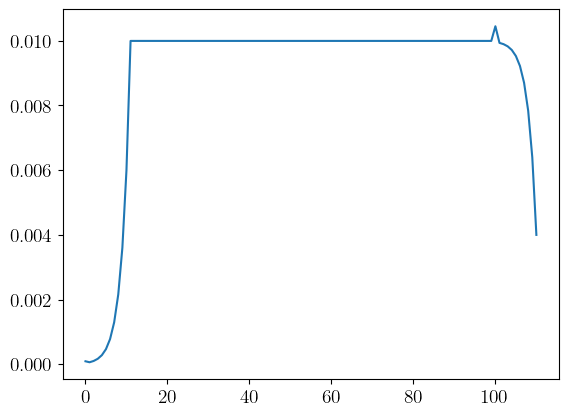

In [29]:
plt.plot(mc.state_values, mc.stationary_distributions[0])

In [20]:
def compute_stationary_dist(model):
    """Compute the stationary distribution of the model."""
    mc = compute_mc(model)
    return mc.state_values, mc.stationary_distributions[0]

In [21]:
# Plots

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


default_model = create_inventory_model()


def plot_ts(model, fontsize=16,
                   figname="./figures/inventory_sim_1.pdf",
                   savefig=False):
    S, s, p, φ, h = model
    X = sim_inventories(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(X, label=r"$X_t$", linewidth=3, alpha=0.6)
    fontdict = {'fontsize': fontsize}
    ax.set_xlabel(r"$t$", fontdict=fontdict)
    ax.set_ylabel("inventory", fontdict=fontdict)
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, S + s + 20)

    if savefig:
        fig.savefig(figname)


def plot_hist(model, fontsize=16,
                   figname="./figures/inventory_sim_2.pdf",
                   savefig=False):
    S, s, p, φ, h = model
    state_values, ψ_star = compute_stationary_dist(model)
    X = sim_inventories(model, 1_000_000)
    histogram = [np.mean(X == i) for i in state_values]

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(state_values, ψ_star, "k-",  linewidth=3, alpha=0.7,
                label=r"$\psi^*$")
    ax.bar(state_values, histogram, alpha=0.7, label="frequency")
    fontdict = {'fontsize': fontsize}
    ax.set_xlabel("state", fontdict=fontdict)

    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, 0.015)

    if savefig:
        fig.savefig(figname)

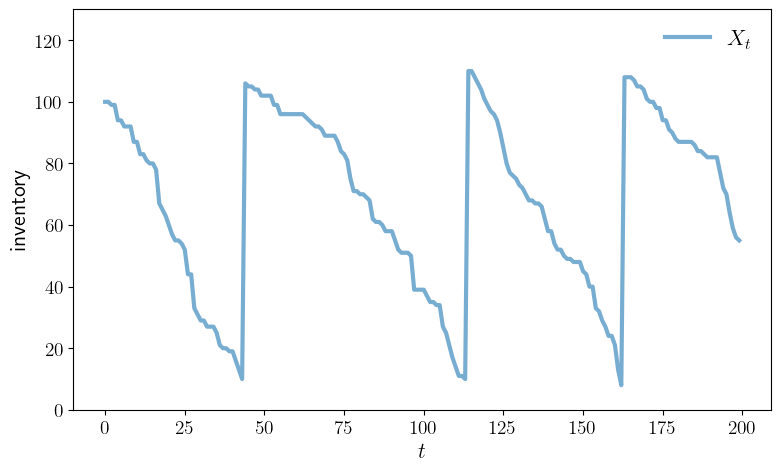

In [22]:
plot_ts(model)

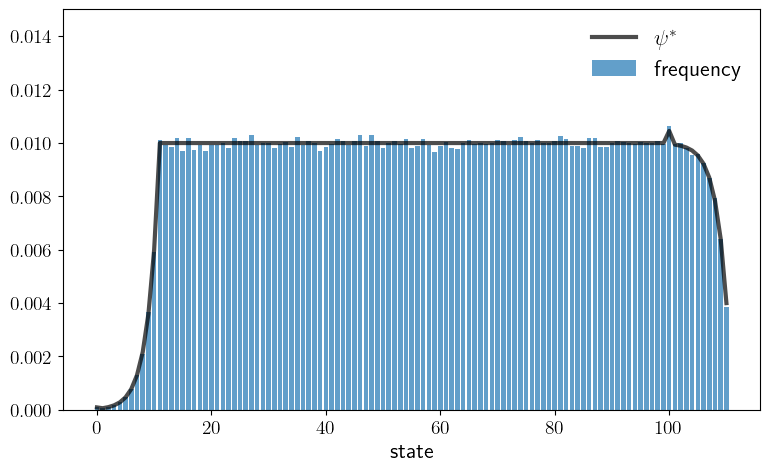

In [25]:
plot_hist(model)